In [106]:
import numpy as np
import pandas as pd
import optuna
from lightgbm import LGBMRegressor
from mlforecast import MLForecast
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [107]:
# Load the data
train_df = pd.read_csv("../output/0_data_cleaning/lightgbm/train_lightgbm.csv").rename(columns={'country_index': 'country', 'co2_including_luc': 'co2'})
test_df = pd.read_csv("../output/0_data_cleaning/lightgbm/test_lightgbm.csv").rename(columns={'country_index': 'country', 'co2_including_luc': 'co2'})

In [108]:
train_df

,year,country,population,gdp,temperature_change_from_co2,cement_co2_lag_1,cement_co2_lag_2,cement_co2_lag_3,coal_co2_lag_1,coal_co2_lag_2,...,gas_co2_lag_1,gas_co2_lag_2,gas_co2_lag_3,land_use_change_co2_lag_1,land_use_change_co2_lag_2,land_use_change_co2_lag_3,oil_co2_lag_1,oil_co2_lag_2,oil_co2_lag_3,co2
0,1931,Argentina,0.007322,0.006480,0.026144,0.000367,0.000370,0.000282,0.001535,0.001696,...,0.000386,0.000390,0.000253,0.170616,0.190037,0.189716,0.001586,0.001654,0.001601,0.043654
1,1932,Argentina,0.007503,0.006261,0.026144,0.000515,0.000402,0.000423,0.001313,0.001655,...,0.000480,0.000386,0.000390,0.157812,0.170616,0.190037,0.002007,0.001586,0.001654,0.041506
2,1933,Argentina,0.007665,0.006560,0.026144,0.000480,0.000564,0.000459,0.001197,0.001416,...,0.000655,0.000480,0.000386,0.150694,0.157812,0.170616,0.002278,0.002007,0.001586,0.040039
3,1934,Argentina,0.007830,0.007097,0.026144,0.000493,0.000525,0.000644,0.001126,0.001291,...,0.000880,0.000655,0.000480,0.145852,0.150694,0.157812,0.002371,0.002278,0.002007,0.039101
4,1935,Argentina,0.007999,0.007418,0.026144,0.000544,0.000540,0.000600,0.001244,0.001215,...,0.001063,0.000880,0.000655,0.142382,0.145852,0.150694,0.002428,0.002371,0.002278,0.038219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,2004,Vietnam,0.060280,0.026500,0.026144,0.018187,0.017601,0.015970,0.006044,0.005604,...,0.004431,0.003490,0.002183,0.157641,0.148809,0.159475,0.011685,0.011342,0.010126,0.053990
3072,2005,Vietnam,0.060905,0.028430,0.026144,0.020003,0.019924,0.020100,0.006577,0.006518,...,0.007456,0.004431,0.003490,0.160666,0.157641,0.148809,0.013424,0.011685,0.011342,0.049060
3073,2006,Vietnam,0.061515,0.030323,0.026144,0.023269,0.021913,0.022752,0.007459,0.007093,...,0.007996,0.007456,0.004431,0.141767,0.160666,0.157641,0.013411,0.013424,0.011685,0.046892
3074,2007,Vietnam,0.062125,0.032394,0.026144,0.023803,0.025491,0.025024,0.008080,0.008044,...,0.009543,0.007996,0.007456,0.133140,0.141767,0.160666,0.012838,0.013411,0.013424,0.050293


In [109]:
# Ensure that 'country' is treated as a string
train_df['country'] = train_df['country'].astype(str)
test_df['country'] = test_df['country'].astype(str)

# Set up the lags
max_lag = 1  # Adjust as necessary
lags = list(range(1, max_lag + 1))

# List of dynamic features (excluding 'co2', 'year', and 'country')
dynamic_features = train_df.columns.drop(['co2', 'year', 'country']).tolist()

In [110]:
# Define the Optuna objective function
def objective(trial):
    # Define the hyperparameter search space
    param = {
        # 'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        # 'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        # 'num_leaves': trial.suggest_int('num_leaves', 15, 50),
        # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
        # "max_depth": trial.suggest_int("max_depth", 3, 10),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        # 'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        # 'lambda_l1': trial.suggest_float('lambda_l1', 1.0, 10.0),
        # 'lambda_l2': trial.suggest_float('lambda_l2', 1.0, 10.0),
        # 'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.1, 0.2),
        # 'random_state': 42,
        # 'objective': 'regression',
        # 'verbosity': 0,
        # 'n_jobs': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        'num_leaves': trial.suggest_int('num_leaves', 15, 60),
        'random_state': 0, 
        'verbosity': -1
    }

    # Initialize the model
    model = LGBMRegressor(**param)

    # Initialize MLForecast
    forecast_model = MLForecast(
        models=[model],
        freq=1,
        lags=lags,
        date_features=None,
        num_threads=-1
    )

    # Fit the model
    forecast_model.fit(
        train_df,
        id_col='country',
        time_col='year',
        target_col='co2',
        static_features=[]
    )

    # Perform cross-validation
    cv_predictions = forecast_model.cross_validation(
        df=train_df,
        h=5,
        n_windows=3,
        #step_size=1,
        id_col='country',
        time_col='year',
        target_col='co2',
        static_features=[]
    )

    # Rename 'LGBMRegressor' to 'co2_predicted'
    cv_predictions = cv_predictions.rename(columns={'LGBMRegressor': 'co2_predicted'})

    # Merge predictions with actual values
    results_train = cv_predictions.merge(
        train_df[['country', 'year', 'co2']],
        on=['country', 'year', 'co2'],
        how='left'
    )

    # Rename 'co2' to 'co2_actual'
    results_train = results_train.rename(columns={'co2': 'co2_actual'})

    # Drop any rows with NaNs
    results_train = results_train.dropna(subset=['co2_actual', 'co2_predicted'])

    # Calculate MAPE
    mape = mean_absolute_percentage_error(results_train['co2_actual'], results_train['co2_predicted'])

    return mape

In [111]:
# Define the Optuna objective function
def objective(trial):
    # Define the hyperparameter search space
    param = {
        # 'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 15, 50),
        # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        # 'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1.0, 10.0),
        # 'lambda_l2': trial.suggest_float('lambda_l2', 1.0, 10.0),
        # 'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.1, 0.2),
        'random_state': 0,
        # 'objective': 'regression',
        'verbosity': -1,
        # 'n_jobs': -1,
    }

    # Initialize the model
    model = LGBMRegressor(**param)

    # Initialize MLForecast
    forecast_model = MLForecast(
        models=[model],
        freq=1,
        lags=lags,
        date_features=None,
        num_threads=-1
    )

    # Fit the model
    forecast_model.fit(
        train_df,
        id_col='country',
        time_col='year',
        target_col='co2',
        static_features=[]
    )

    # Perform cross-validation
    cv_predictions = forecast_model.cross_validation(
        df=train_df,
        h=5,
        n_windows=3,
        #step_size=1,
        id_col='country',
        time_col='year',
        target_col='co2',
        static_features=[]
    )

    # Rename 'LGBMRegressor' to 'co2_predicted'
    cv_predictions = cv_predictions.rename(columns={'LGBMRegressor': 'co2_predicted'})

    # Merge predictions with actual values
    results_train = cv_predictions.merge(
        train_df[['country', 'year', 'co2']],
        on=['country', 'year', 'co2'],
        how='left'
    )

    # Rename 'co2' to 'co2_actual'
    results_train = results_train.rename(columns={'co2': 'co2_actual'})

    # Drop any rows with NaNs
    results_train = results_train.dropna(subset=['co2_actual', 'co2_predicted'])

    # Calculate MAPE
    mape = mean_absolute_percentage_error(results_train['co2_actual'], results_train['co2_predicted'])

    return mape

In [112]:
# Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-11-15 10:41:14,302] A new study created in memory with name: no-name-ab419ac6-41ce-459e-8b1f-a873aecfbeef
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/mlforecast/core.py:185: UserWarning: Setting num_threads to 1.
  warnings.warn("Setting num_threads to 1.")
[I 2024-11-15 10:41:14,890] Trial 0 finished with value: 0.13992954437056382 and parameters: {'learning_rate': 0.04100927268675754, 'num_leaves': 48, 'max_depth': 7, 'lambda_l1': 7.486092344335378}. Best is trial 0 with value: 0.13992954437056382.
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/mlforecast/core.py:185: UserWarning: Setting num_threads to 1.
  warnings.warn("Setting num_threads to 1.")
[I 2024-11-15 10:41:15,455] Trial 1 finished with value: 0.10962999515219028 and parameters: {'learning_rate': 0.08912158066445212, 'num_leaves': 19, 'max_depth': 6, 'lambda_l1': 3.725365163207582}. Best is trial 1 with value: 0.10962999515219028.
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/mlforecas

Best Hyperparameters: {'learning_rate': 0.07818558690933249, 'num_leaves': 21, 'max_depth': 2, 'lambda_l1': 1.3258447507576776}


In [113]:
best_params

{'learning_rate': 0.07818558690933249,
 'num_leaves': 21,
 'max_depth': 2,
 'lambda_l1': 1.3258447507576776}

In [114]:
# Initialize the model with best hyperparameters
best_model = LGBMRegressor(
    **best_params,
    #objective='regression',
    #random_state=42,
    verbosity=-1,
    random_state = 0,
    #n_jobs=-1
)

# Initialize MLForecast with the best model
forecast_model = MLForecast(
    models=[best_model],
    freq=1,
    #lags=lags,
    date_features=None,
    num_threads=-1
)

# Fit the model on the entire training data
forecast_model.fit(
    train_df,
    id_col='country',
    time_col='year',
    target_col='co2',
    static_features=[],
    fitted=True
)

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/mlforecast/core.py:185: UserWarning: Setting num_threads to 1.
  warnings.warn("Setting num_threads to 1.")


MLForecast(models=[LGBMRegressor], freq=1, lag_features=[], date_features=[], num_threads=1)

In [115]:
#TRAIN DATA
# Get the fitted values on the training data
fitted_values = forecast_model.forecast_fitted_values()

# Rename 'LGBMRegressor' to 'co2_predicted'
fitted_values = fitted_values.rename(columns={'LGBMRegressor': 'co2_predicted'})

# Merge fitted values with actual values
results_train = fitted_values.merge(
    train_df[['country', 'year', 'co2']],
    on=['country', 'year', 'co2'],
    how='left'
)

# Rename 'co2' to 'co2_actual'
results_train = results_train.rename(columns={'co2': 'co2_actual'})

# Drop any rows with NaNs
results_train = results_train.dropna(subset=['co2_actual', 'co2_predicted'])

# Calculate the Mean Absolute Percentage Error (MAPE) on the training set
train_mape = mean_absolute_percentage_error(results_train['co2_actual'], results_train['co2_predicted'])
print(f"Train MAPE: {train_mape}")

Train MAPE: 49011144151.95938


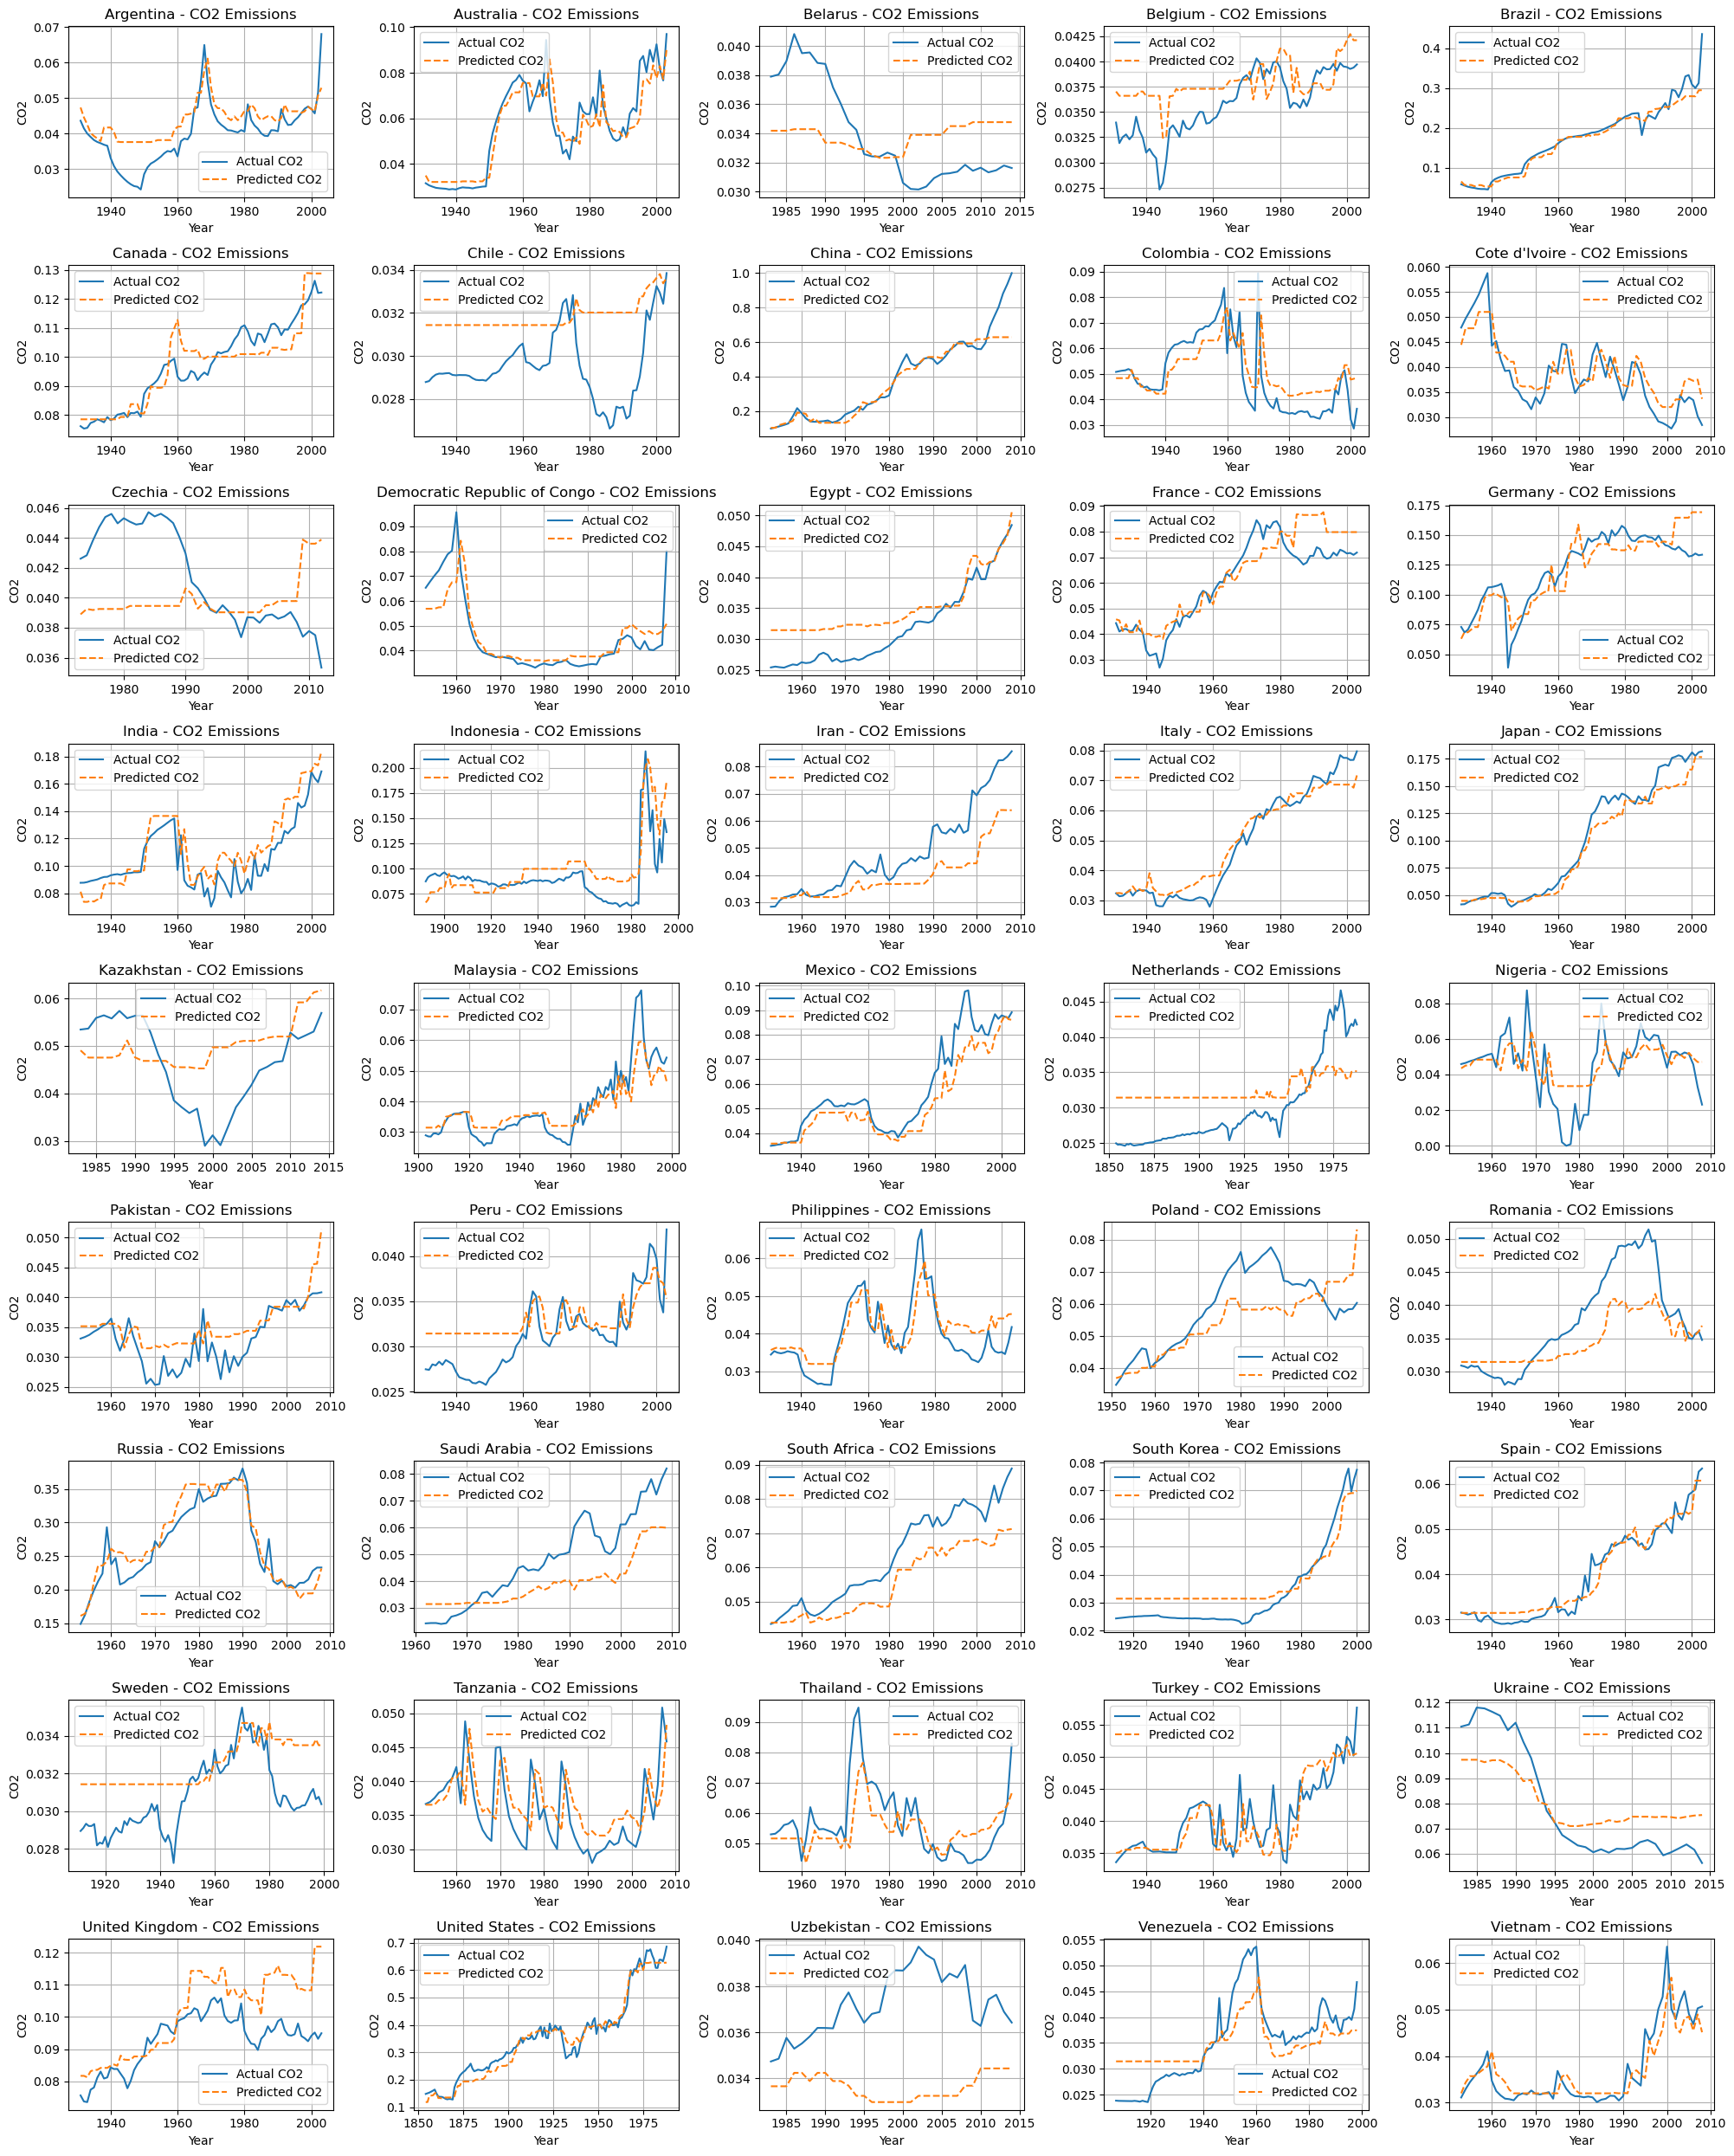

In [116]:
#TRAIN DATA
# Define the layout for subplots
num_rows = 9
num_cols = 5
countries = results_train['country'].unique()  # Get unique countries

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25), squeeze=False)
axes = axes.flatten()

for i, country in enumerate(countries):
    # Filter results for the current country
    country_results = results_train[results_train['country'] == country]
    ax = axes[i]
    
    # Plot the actual and predicted CO2 for each country
    ax.plot(country_results['year'], country_results['co2_actual'], label='Actual CO2')
    ax.plot(country_results['year'], country_results['co2_predicted'], label='Predicted CO2', linestyle='--')
    
    ax.set_title(f'{country} - CO2 Emissions')
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2')
    ax.grid(True)
    
    ax.legend()

# Delete any remaining unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [117]:
# TEST DATA
# Initialize an empty list to collect predictions
all_predictions = []

# Loop over each country in the test set
for country in test_df['country'].unique():
    # Select test data specific to this country
    country_test_data = test_df[test_df['country'] == country].copy()
    
    # Set the horizon to the number of years to predict for this country
    horizon = country_test_data['year'].nunique()
    
    # Drop the target column from the country-specific test data to avoid leakage
    country_test_features = country_test_data.drop(columns=['co2'])

    # Predict using the exact test data for this country
    country_predictions = forecast_model.predict(h=horizon, X_df=country_test_features, ids = [country])
    
    # Add country identifier to the predictions for merging later
    country_predictions['country'] = country
    
    # Append to the list of all predictions
    all_predictions.append(country_predictions)

# Concatenate all country-specific predictions
predictions_df = pd.concat(all_predictions).reset_index(drop=True).rename(columns={'LGBMRegressor': 'co2'})

# Merge predictions with actual train values for comparison
results_test = predictions_df.merge(
    test_df[['country', 'year', 'co2']],
    on=['country', 'year'],
    how='left',
    suffixes=('_predicted', '_actual')
)

# # Display the first few rows of the predictions vs actuals
print(results_test)

# # Calculate the Mean Absolute Percentage Error (MAPE) on the train set
mape = mean_absolute_percentage_error(results_test['co2_actual'], results_test['co2_predicted'])
print(f"Test MAPE: {mape}")

       country  year  co2_predicted  co2_actual
0    Argentina  2004       0.067029    0.079424
1    Argentina  2005       0.070556    0.083970
2    Argentina  2006       0.073759    0.086260
3    Argentina  2007       0.074368    0.067298
4    Argentina  2008       0.069095    0.059847
..         ...   ...            ...         ...
783    Vietnam  2018       0.086289    0.086123
784    Vietnam  2019       0.089740    0.096704
785    Vietnam  2020       0.093194    0.099593
786    Vietnam  2021       0.096690    0.098647
787    Vietnam  2022       0.096690    0.097387

[788 rows x 4 columns]
Test MAPE: 0.2341261491033087


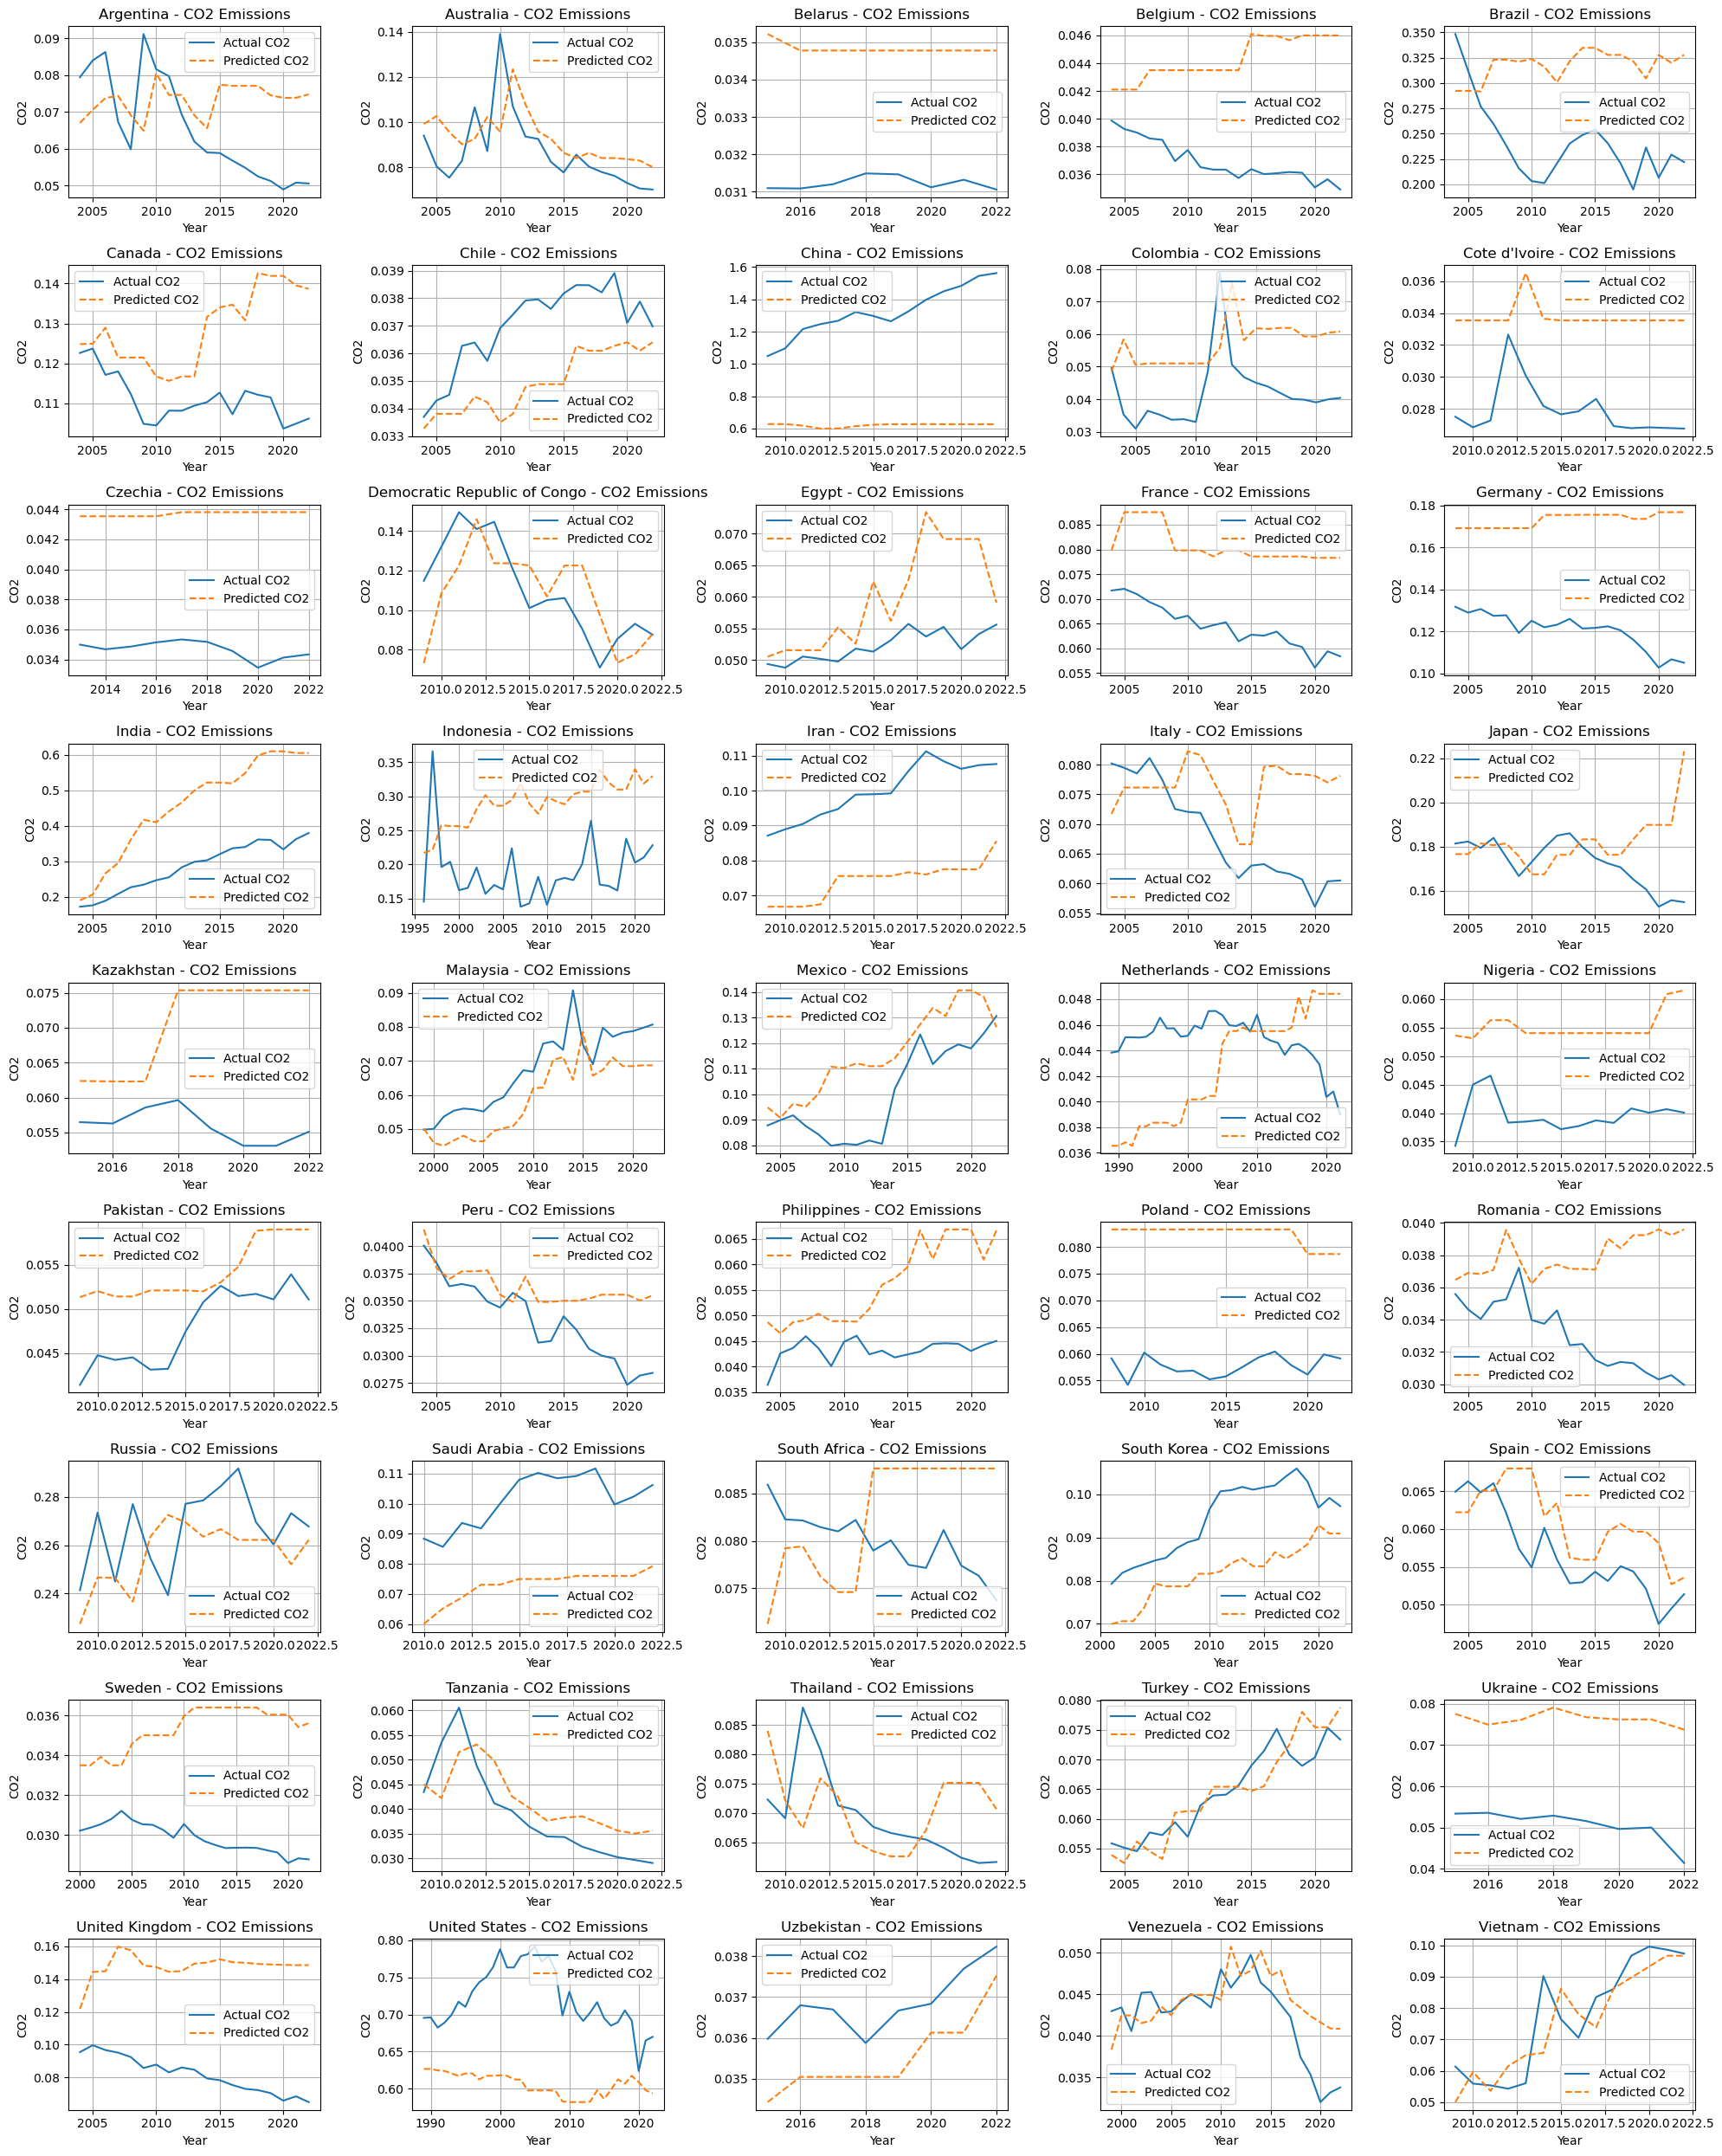

In [118]:
#TEST DATA
# Define the layout for subplots
num_rows = 9
num_cols = 5
countries = results_test['country'].unique()  # Get unique countries

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25), squeeze=False)
axes = axes.flatten()

for i, country in enumerate(countries):
    # Filter results for the current country
    country_results = results_test[results_test['country'] == country]
    ax = axes[i]
    
    # Plot the actual and predicted CO2 for each country
    ax.plot(country_results['year'], country_results['co2_actual'], label='Actual CO2')
    ax.plot(country_results['year'], country_results['co2_predicted'], label='Predicted CO2', linestyle='--')
    
    ax.set_title(f'{country} - CO2 Emissions')
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2')
    ax.grid(True)
    
    ax.legend()

# Delete any remaining unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()